<a href="https://colab.research.google.com/github/Sonali2824/age_and_gender_prediction/blob/main/age_gender_submit_model_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

Number of files in train_val/:5000
Size of the Image: 128 128 3


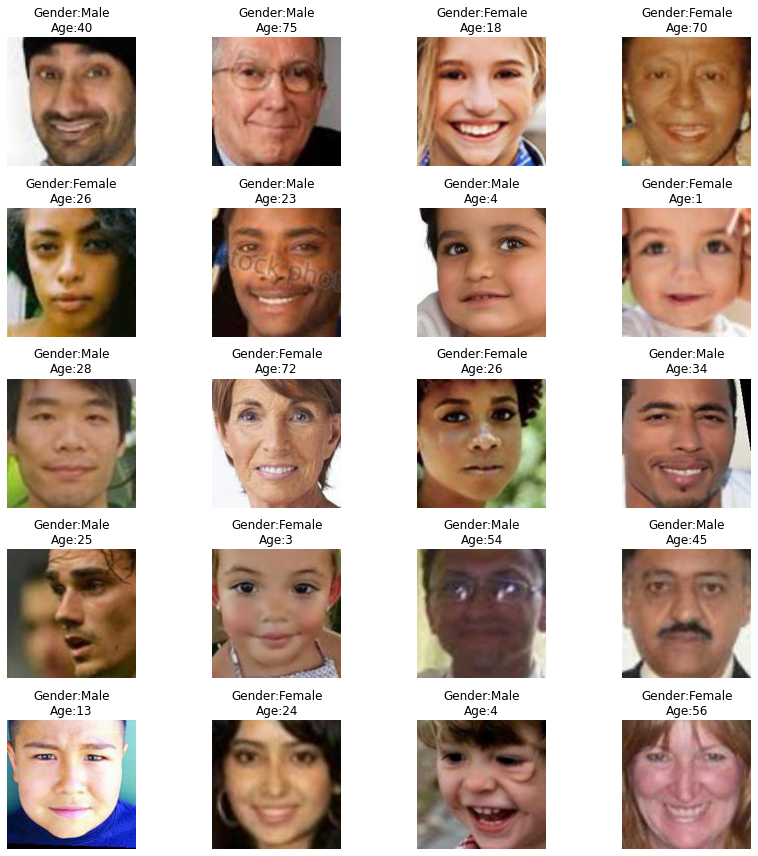

In [2]:
#
# Add your code here
#
import os
import matplotlib.pyplot as plt

folder = '/content/drive/MyDrive/train_val'

# Checking if there are 5000 training files
num_files = len([f for f in os.listdir(folder)if os.path.isfile(os.path.join(folder, f))])
print("Number of files in train_val/:%d" % (num_files))  

fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.ravel()

for i, filename in enumerate(os.listdir(folder)):
    if i == 20:
        break
    # Printing the Size of the Image
    if i == 0:
      filepath = os.path.join(folder, filename)
      img = plt.imread(filepath)
      height, width, channels = img.shape
      print("Size of the Image:", height, width, channels)

    filepath = os.path.join(folder, filename)
    img = plt.imread(filepath)
    axs[i].imshow(img)
    substrings = filename.split('_')
    if substrings[1] == "0":
      gender = "Male"
    else:
      gender = "Female"
    axs[i].axis('off')
    axs[i].set_title(f'Gender:{gender}\nAge:{substrings[0]}')

plt.tight_layout()
plt.show()


## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [3]:
#
# Add your code here
#
import os
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array


image_files = os.listdir(folder)

# Obtaining the x, y_age and y_gender lists from the dataset
x = []
y_age = []
y_gender = []

for images in image_files:
    label = images.split('_')
    age = int(label[0])
    gender = int(label[1])
    img = load_img(folder+"/"+images)
    img = img_to_array(img)
    x.append(img)
    y_age.append(age)
    y_gender.append(gender)
    
x = np.array(x)
y_age = np.array(y_age)
y_gender = np.array(y_gender)

# Normalizing images as per instructions in Step 1 point 1
x = x / 255.0

In [4]:
# Shuffling the data to ensure randomness in the data
n = x.shape[0]
indices = np.random.permutation(n)
split_index = int(0.8 * n)  # Splitting data into 80% for training set and 20% for validation set

train_indices = indices[:split_index]
val_indices = indices[split_index:]


x_train, y_train = x[train_indices], [y_age[train_indices], y_gender[train_indices]]
x_val, y_val = x[val_indices], [y_age[val_indices], y_gender[val_indices]]


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [5]:
#
# Add your code here
#
# Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Defining train_datagenerator to perform augmentation on one image and display the results in the next cell
train_datagenerator = ImageDataGenerator(
          width_shift_range=.10,
          height_shift_range=.10,
          rotation_range=30,
          horizontal_flip=True)

# Defining augmentation for the train dataset
def generate_train_data_augmentation(x, y):
  train_datagenerator = ImageDataGenerator(
            width_shift_range=.10,
            height_shift_range=.10,
            rotation_range=30,
            horizontal_flip=True)

  age_generated = train_datagenerator.flow(x, y[0], batch_size=32, seed = 1)
  gender_generated = train_datagenerator.flow(x, y[1], batch_size=32, seed = 1)

  while True:
    X1 = age_generated.next()
    X2 = gender_generated.next()
    yield X1[0], (X1[1], X2[1])

# Creating the  generator
train_generated = generate_train_data_augmentation(x_train,[y_train[0], y_train[1]])

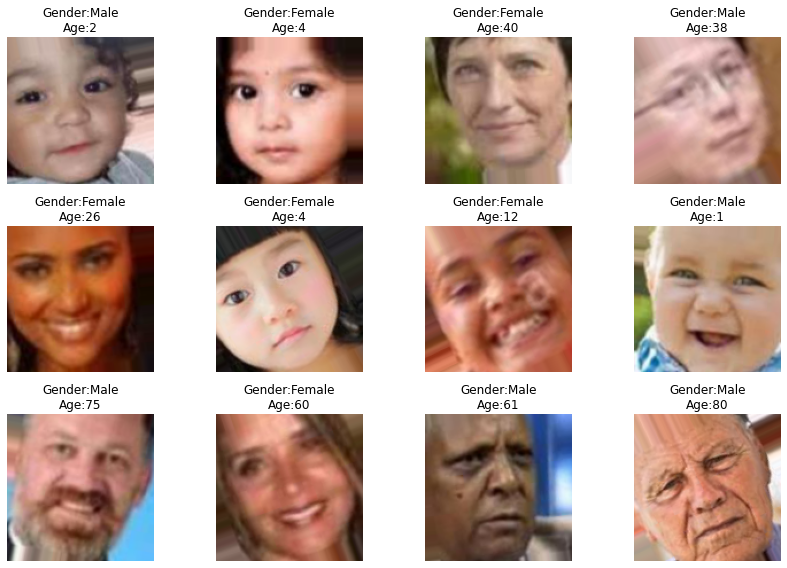


******************* Data Augmentation on One Image ************************************



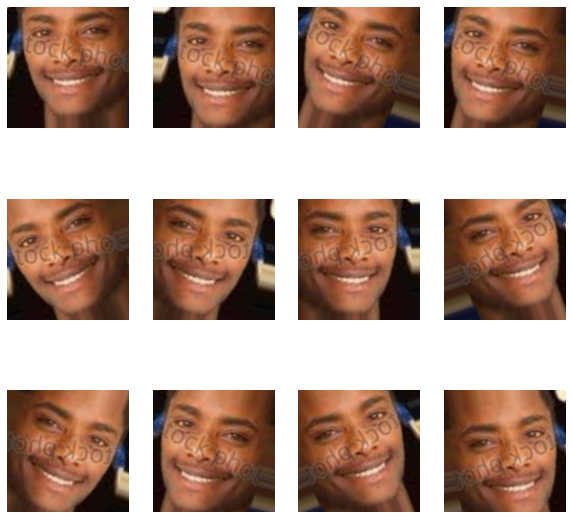

In [6]:
import matplotlib.pyplot as plt
import cv2
import keras.utils as image
from tensorflow.keras.utils import array_to_img

x_batch, y_batch = next(train_generated)

# Display the images
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(image.array_to_img(x_batch[i]), cmap="gray")

    if y_batch[1][i] == 0:
      gender = "Male"
    else:
      gender = "Female"
    ax.axis('off')
    ax.set_title(f'Gender:{gender}\nAge:{y_batch[0][i]}')
    

plt.tight_layout()
plt.show()


print()
print("******************* Data Augmentation on One Image ************************************")
print()

image_files = os.listdir(folder)
selected_image = image_files[5]
selected_image = image.load_img((folder+"/"+selected_image), target_size=(128,128)) # resize it
selected_image = image.img_to_array(selected_image)
selected_image = selected_image.reshape((1,)+selected_image.shape) 
i = 0
plt.figure(figsize=(10,10))
for batch in train_datagenerator.flow(selected_image,batch_size=1):
  plt.subplot(3,4,i+1)
  plt.axis("off")
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i%12 == 0:
    break
plt.show()

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

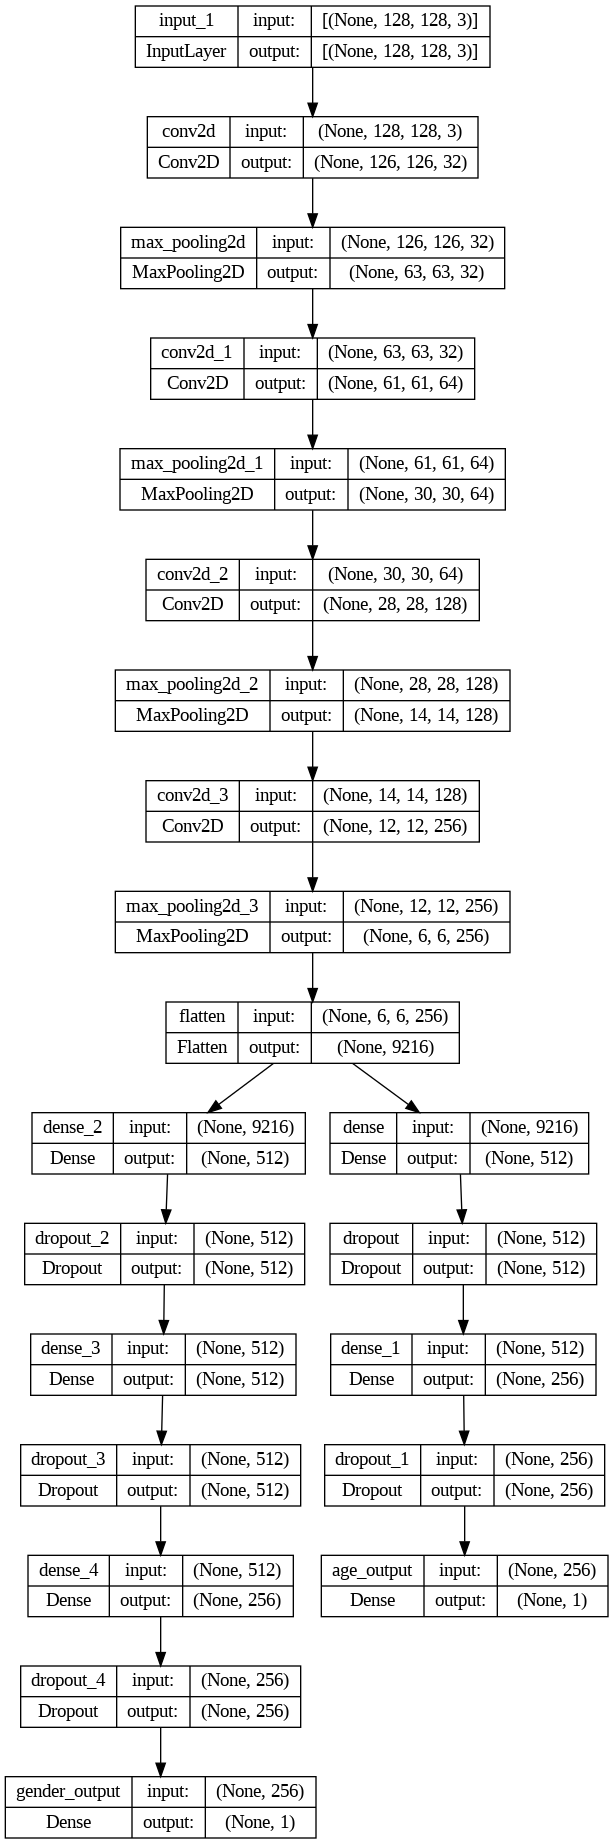

In [7]:
#
# Add your code here
#

# Defining Model A
from keras.models import Model
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

input_layer = Input(shape=(128, 128, 3))

convolution_layer_1= Conv2D(32, kernel_size=(3,3), activation = 'relu') (input_layer)
max_pooling_1 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_1)

convolution_layer_2= Conv2D(64, kernel_size=(3,3), activation = 'relu') (max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_2)

convolution_layer_3= Conv2D(128, kernel_size=(3,3), activation = 'relu') (max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_3)

convolution_layer_4= Conv2D(256, kernel_size=(3,3), activation = 'relu') (max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2)) (convolution_layer_4)

flatten = Flatten()(max_pooling_4)

dense_1 = Dense(512, activation='relu')(flatten)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(256, activation='relu')(dropout_1)
dropout_2 = Dropout(0.3) (dense_2)
output_1 = Dense(1, activation='linear', name='age_output') (dropout_2)

dense_3 = Dense(512, activation='relu')(flatten)
dropout_3 = Dropout(0.3)(dense_3)
dense_4 = Dense(512, activation='relu')(dropout_3)
dropout_4 = Dropout(0.3)(dense_4)
dense_5 = Dense(256, activation='relu')(dropout_4)
dropout_5 = Dropout(0.3) (dense_5)
output_2 = Dense(1, activation='sigmoid', name='gender_output') (dropout_5)

modelA = Model(inputs=input_layer, outputs = [output_1,output_2])
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [9]:
#
# Add your code here
#
# Compiling the Code
from tensorflow.keras.optimizers import Adam
modelA.compile(optimizer=Adam(0.001), 
              loss={
                  'age_output': 'mean_squared_error', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'MAE', 
                  'gender_output': 'accuracy'})

# Fitting the Model
batch_size = 32
history = modelA.fit(train_generated,
                        steps_per_epoch= x_train.shape[0] // batch_size,
                        epochs=300,
                        validation_data=(x_val, (y_val[0],y_val[1])))


Epoch 1/300
125/125 [==============================] - 37s 265ms/step - loss: 516.7645 - age_output_loss: 516.0454 - gender_output_loss: 0.7191 - age_output_MAE: 17.4582 - gender_output_accuracy: 0.5055 - val_loss: 386.2224 - val_age_output_loss: 385.5314 - val_gender_output_loss: 0.6910 - val_age_output_MAE: 15.2344 - val_gender_output_accuracy: 0.5350
Epoch 2/300
125/125 [==============================] - 31s 248ms/step - loss: 431.0053 - age_output_loss: 430.3122 - gender_output_loss: 0.6933 - age_output_MAE: 15.8549 - gender_output_accuracy: 0.5050 - val_loss: 376.6979 - val_age_output_loss: 376.0058 - val_gender_output_loss: 0.6920 - val_age_output_MAE: 14.6122 - val_gender_output_accuracy: 0.5350
Epoch 3/300
125/125 [==============================] - 43s 343ms/step - loss: 412.6666 - age_output_loss: 411.9734 - gender_output_loss: 0.6933 - age_output_MAE: 15.5805 - gender_output_accuracy: 0.4975 - val_loss: 405.7756 - val_age_output_loss: 405.0840 - val_gender_output_loss: 0.6916

In [10]:
# Saving the Model
import os

model_folder = '/content/drive/MyDrive/Colab Notebooks/models'
if not os.path.exists(model_folder):
  os.mkdir(model_folder)
modelA.save(model_folder+'/age_gender_A.h5') 
 

In [13]:
# Evaluate the model on the validation data
loss, age_loss, gender_loss, age_mae, gender_acc = (modelA.evaluate(x_val, [y_val[0], y_val[1]]))

# Print the loss and metric values for each output
print('Total loss: {:.4f}'.format(loss))
print('Age loss: {:.4f}, Age MAE: {:.4f}'.format(age_loss, age_mae))
print('Gender loss: {:.4f}, Gender accuracy: {:.4f}%'.format(gender_loss, gender_acc*100))

32/32 [==============================] - 0s 10ms/step - loss: 89.5415 - age_output_loss: 89.2195 - gender_output_loss: 0.3219 - age_output_MAE: 6.8375 - gender_output_accuracy: 0.8670
Total loss: 89.5415
Age loss: 89.2195, Age MAE: 6.8375
Gender loss: 0.3219, Gender accuracy: 86.7000%


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


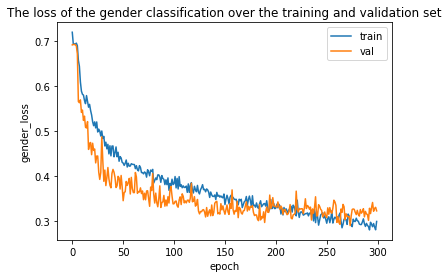

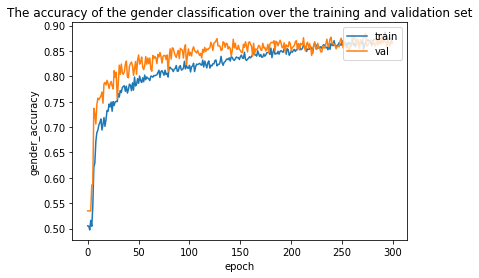

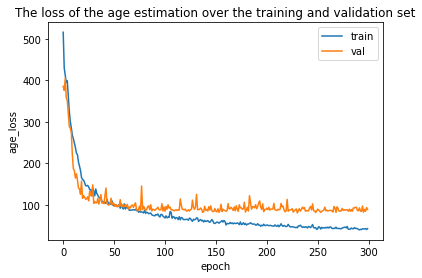

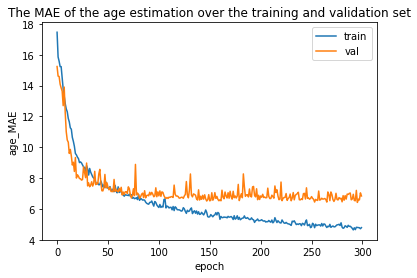

In [14]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender_loss')
plt.ylabel('gender_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title("The loss of the gender classification over the training and validation set")
plt.show()

plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender_accuracy')
plt.ylabel('gender_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title("The accuracy of the gender classification over the training and validation set")
plt.show()

plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age_loss')
plt.ylabel('age_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title("The loss of the age estimation over the training and validation set")
plt.show()


plt.plot(history.history['age_output_MAE'])
plt.plot(history.history['val_age_output_MAE'])
plt.title('age_MAE')
plt.ylabel('age_MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.title("The MAE of the age estimation over the training and validation set")
plt.show()



## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [ ]:
#
# Add your code here
#

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
#
# Add your code here
#

modelB.save(your_model_folder+"age_gender_B.h5")

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

In [ ]:
#
# Add your code here
#


## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#